<a href="https://colab.research.google.com/github/sunghyunc7/Flowise/blob/main/main%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 새 섹션

plot_cell_sector.py

In [17]:
import json
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter


In [18]:
# -----------------------------
# 유틸리티: 하버사인 거리 (km)
# -----------------------------
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088  # 평균 지구 반지름(km)
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlmb/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# -----------------------------
# 데이터 로드
# -----------------------------
with open('data/cell_info.json', 'r') as f:
    cells = json.load(f)

# -----------------------------
# 사이트(동일 위경도) 단위로 묶기
# key: (lat, lon)  value: 해당 위치의 섹터 리스트
# -----------------------------
site_to_cells = defaultdict(list)
for cell in cells:
    key = (cell['lat'], cell['lon'])
    site_to_cells[key].append(cell)

sites = list(site_to_cells.keys())  # [(lat, lon), ...]

# -----------------------------
# 각 사이트의 "가장 가까운 이웃 사이트" 거리 계산
# -----------------------------
nearest_dist_km = {}  # key: (lat, lon) -> 이웃까지 최소거리(km)
n = len(sites)
if n == 1:
    only_site = sites[0]
    nearest_dist_km[only_site] = 0.5
else:
    for i in range(n):
        lat1, lon1 = sites[i]
        best = float('inf')
        for j in range(n):
            if i == j:
                continue
            lat2, lon2 = sites[j]
            d = haversine_km(lat1, lon1, lat2, lon2)
            if d < best:
                best = d
        if best == float('inf') or best <= 0:
            best = 0.5
        nearest_dist_km[sites[i]] = best

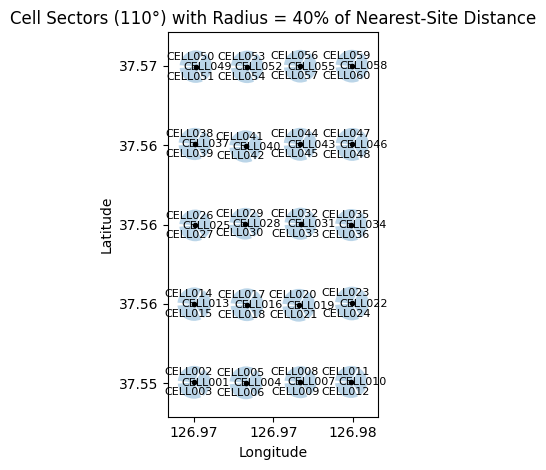

In [21]:
# -----------------------------
# 그리기 설정
# -----------------------------
km_per_deg_lat = 111.32  # 1도(위도) ≈ 111.32 km
sector_angle = 110.0     # 요구사항: 120° → 110°
half_angle = sector_angle / 2.0

fig, ax = plt.subplots()

for (site_lat, site_lon), sector_list in site_to_cells.items():
    # 이 사이트의 반경 = "가장 가까운 이웃 사이트 거리"의 40%
    site_neighbor_km = nearest_dist_km[(site_lat, site_lon)]
    radius_km = 0.4 * site_neighbor_km

    # km → 위도상 degree 근사 변환
    radius_deg = radius_km / km_per_deg_lat

    # 사이트 위치 점
    ax.plot(site_lon, site_lat, 'ko', markersize=3, zorder=3)

    # 이 사이트의 모든 섹터(보통 3개) 그리기
    for idx, cell in enumerate(sector_list):
        azimuth = float(cell['azimuth'])
        start_angle = azimuth - half_angle
        end_angle = azimuth + half_angle

        # 부채꼴
        wedge = Wedge((site_lon, site_lat), radius_deg, start_angle, end_angle,
                      facecolor='C0', alpha=0.3, edgecolor='none', zorder=1)
        ax.add_patch(wedge)

        # ===== 라벨 겹침 방지: 섹터 중심각 방향으로 오프셋 배치 =====
        # 중심각(라벨 방향)
        mid_angle_deg = azimuth
        mid_angle_rad = math.radians(mid_angle_deg)

        # 라벨 배치 반경: 반지름의 70% 지점 (필요 시 0.6~0.8 사이로 조정)
        label_r = 0.7 * radius_deg

        # 같은 azimuth가 중복될 때 아주 미세한 각도 보정(±1.5°씩 번갈아)
        jitter_deg = (idx % 3 - 1) * 1.5  # -1.5, 0, +1.5 반복
        mid_angle_rad_j = math.radians(mid_angle_deg + jitter_deg)

        dx = label_r * math.cos(mid_angle_rad_j)
        dy = label_r * math.sin(mid_angle_rad_j)

        ax.text(site_lon + dx, site_lat + dy, str(cell['id']),
                ha='center', va='center', fontsize=8, zorder=4)

# 축 라벨 및 포맷(소수점 2자리)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Cell Sectors (110°) with Radius = 40% of Nearest-Site Distance')

# 눈금 표시 형식: 소수점 둘째 자리
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# 새 섹션

main.py

In [26]:
import json
import math
import matplotlib.pyplot as plt
from core.ta_processor import get_ta_distance_range
from core.sector_model import is_within_sector
from core.likelihood_estimator import calculate_weight
from core.terrain_checker import sample_elevation_along_path, is_los
from utils.geo import destination_point
from utils.visualization_dem import plot_dem, plot_elevation_profile
import rasterio
from rasterio.plot import show as rio_show

In [27]:
# === [1] 측정 데이터 로딩 ===
with open("data/cell_info.json", "r") as f:
    cell_info = {cell["id"]: cell for cell in json.load(f)}

with open("data/ue_measurement.json", "r") as f:
    measurement = json.load(f)

serving_id = measurement["serving_cell"]["id"]
serving = cell_info[serving_id].copy()
serving["ta"] = measurement["serving_cell"]["ta"]

neighbors = []
for cid, rsrp in measurement["neighbor_cells"].items():
    cell = cell_info[cid].copy()
    cell["rsrp"] = rsrp
    neighbors.append(cell)
dem_path = "data/terrain_dem.tif"
dem_dataset = rasterio.open(dem_path)

# === [2] TA 기반 거리 범위 계산 ===
r_min, r_max = get_ta_distance_range(serving["ta"])

# === [3] TA + 섹터 범위 내 후보 위치 생성 ===
candidate_points = []
for dist in range(int(r_min), int(r_max) + 1, 50):  # 거리 간격 50m
    for bearing in range(0, 360, 5):                # 각도 간격 5도
        if is_within_sector(serving["azimuth"], bearing, 65):  # 섹터 HPBW 65도
            lat, lon = destination_point(serving["lat"], serving["lon"], bearing, dist)
            candidate_points.append((lat, lon))

# === [4] 후보 위치별 RSRP 기반 가중치 계산 + LOS 필터 ===
weighted_points = []
for pt in candidate_points:
    los_all = True
    for cell in [serving] + neighbors:
        elevations, _, _ = sample_elevation_along_path(
            dem_dataset, (cell["lat"], cell["lon"]), pt
        )
        if not is_los(elevations):
            los_all = False
            break
    if not los_all:
        continue

    score = calculate_weight(pt, neighbors)
    weighted_points.append((pt[0], pt[1], score))

# === [5] 최종 추정 위치 선택 ===
best_point = max(weighted_points, key=lambda x: x[2])
best_lat, best_lon, best_score = best_point
print(f"[추정 위치] 위도: {best_lat:.6f}, 경도: {best_lon:.6f}, 우도 점수: {best_score:.3f}")

# 좌표를 km 단위로 환산하여 중앙을 (0,0)으로 맞춤
lats, lons, weights = zip(*weighted_points)
center_lat = (max(lats) + min(lats)) / 2
center_lon = (max(lons) + min(lons)) / 2
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * math.cos(math.radians(center_lat))
xs = [(lon - center_lon) * km_per_deg_lon for lon in lons]
ys = [(lat - center_lat) * km_per_deg_lat for lat in lats]
serving_x = (serving["lon"] - center_lon) * km_per_deg_lon
serving_y = (serving["lat"] - center_lat) * km_per_deg_lat
neighbor_xy = [
    ((cell["lon"] - center_lon) * km_per_deg_lon,
     (cell["lat"] - center_lat) * km_per_deg_lat)
    for cell in neighbors
]
best_x = (best_lon - center_lon) * km_per_deg_lon
best_y = (best_lat - center_lat) * km_per_deg_lat


[추정 위치] 위도: 37.552529, 경도: 126.970835, 우도 점수: 0.000


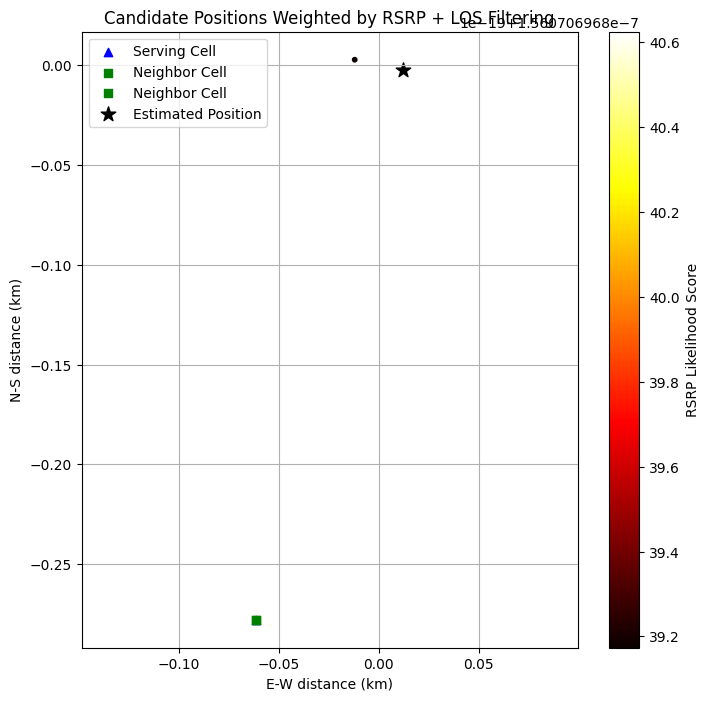

In [28]:
# === [6] 시각화 (가중치 히트맵) ===
plt.figure(figsize=(8, 8))
sc = plt.scatter(xs, ys, c=weights, cmap='hot', s=10)
plt.scatter([serving_x], [serving_y], c='blue', marker='^', label="Serving Cell")
for (nx, ny) in neighbor_xy:
    plt.scatter(nx, ny, c='green', marker='s', label="Neighbor Cell")
plt.scatter([best_x], [best_y], c='black', marker='*', s=120, label="Estimated Position")
plt.colorbar(sc, label="RSRP Likelihood Score")
plt.title("Candidate Positions Weighted by RSRP + LOS Filtering")
plt.xlabel("E-W distance (km)")
plt.ylabel("N-S distance (km)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


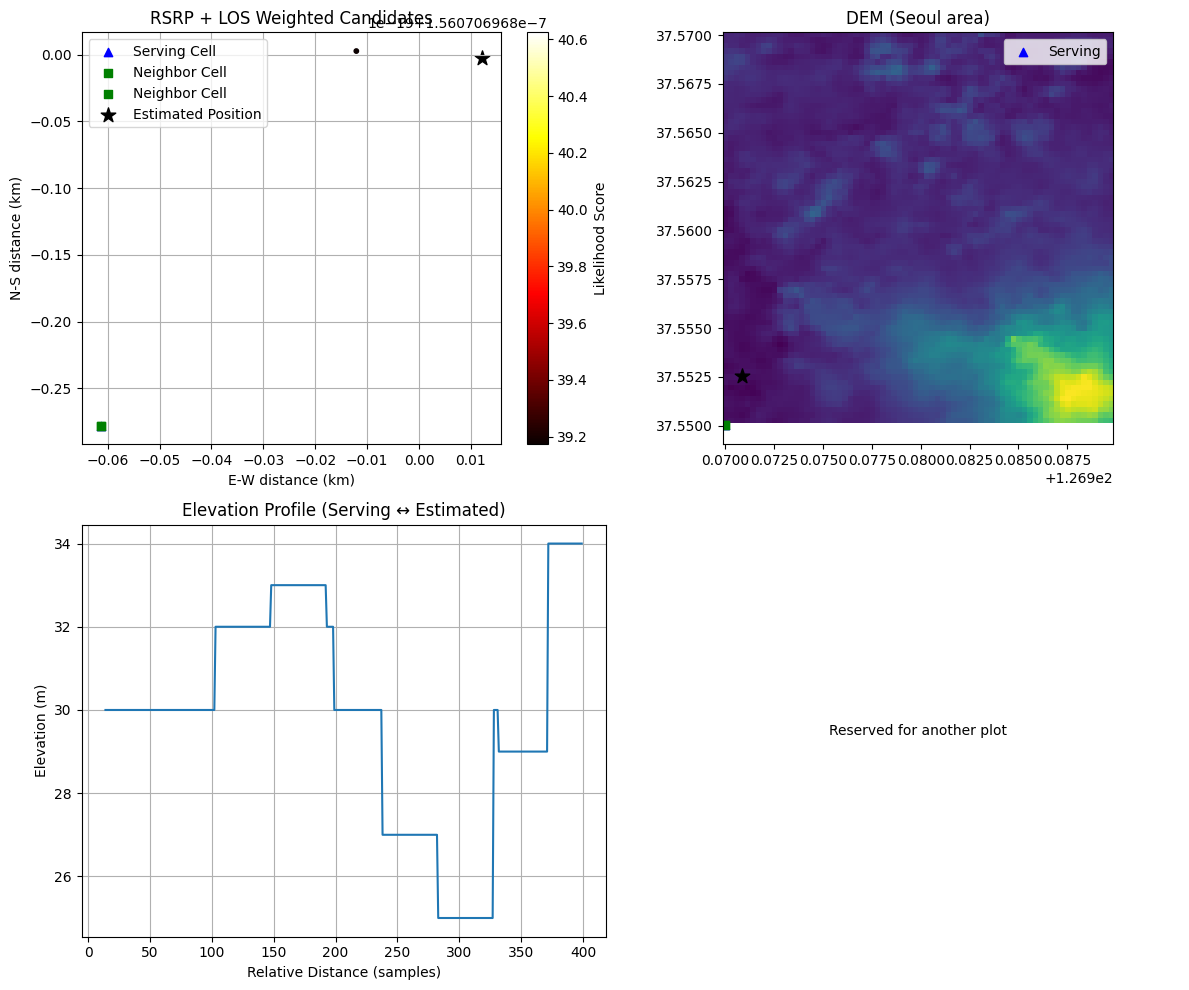

In [29]:
# === [7] 통합 시각화 ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# (1) 후보 위치 히트맵
ax1 = axes[0, 0]
sc = ax1.scatter(xs, ys, c=weights, cmap='hot', s=10)
ax1.scatter([serving_x], [serving_y], c='blue', marker='^', label="Serving Cell")
for (nx, ny) in neighbor_xy:
    ax1.scatter(nx, ny, c='green', marker='s', label="Neighbor Cell")
ax1.scatter([best_x], [best_y], c='black', marker='*', s=120, label="Estimated Position")
ax1.set_title("RSRP + LOS Weighted Candidates")
ax1.set_xlabel("E-W distance (km)"); ax1.set_ylabel("N-S distance (km)")
ax1.legend(); ax1.grid(True)
fig.colorbar(sc, ax=ax1, label="Likelihood Score")

# (2) DEM 지도
ax2 = axes[0, 1]
rio_show(dem_dataset, ax=ax2)
ax2.set_title("DEM (Seoul area)")
# 포인트 표시
ax2.scatter(serving["lon"], serving["lat"], marker='^', c='blue', label="Serving")
for cell in neighbors:
    ax2.scatter(cell["lon"], cell["lat"], marker='s', c='green')
ax2.scatter(best_lon, best_lat, marker='*', c='black', s=120)
ax2.legend()

# (3) 서빙셀 ↔ 추정위치 고도 프로파일
ax3 = axes[1, 0]
from utils.visualization_dem import sample_profile
elev = sample_profile(dem_path, (serving["lat"], serving["lon"]), (best_lat, best_lon), num_samples=400)
ax3.plot(range(len(elev)), elev)
ax3.set_title("Elevation Profile (Serving ↔ Estimated)")
ax3.set_xlabel("Relative Distance (samples)")
ax3.set_ylabel("Elevation (m)")
ax3.grid(True)

# (4) 빈칸 또는 다른 분석 그래프
ax4 = axes[1, 1]
ax4.axis("off")
ax4.text(0.5, 0.5, "Reserved for another plot", ha='center', va='center')

plt.tight_layout()
plt.show()
dem_dataset.close()
